# Jeff Myers
## San Francisco Housing Rental Analysis

In [24]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
import panel as pn
from panel.interact import interact
from panel import widgets
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact


%matplotlib inline

In [25]:
# Read the Mapbox API key and print type
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_token)
print(type(mapbox_token))

<class 'str'>


### Load Data

In [26]:
# Read the census data into a Pandas DataFrame
file_path = Path("Resources/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182946,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


### Housing Units Per Year

In [27]:
# Calculate the mean number of housing units per year 
housing_units = sfo_data["housing_units"].groupby([sfo_data.index]).mean()
housing_units

year
2010    372560
2011    374507
2012    376454
2013    378401
2014    380348
2015    382295
2016    384242
Name: housing_units, dtype: int64

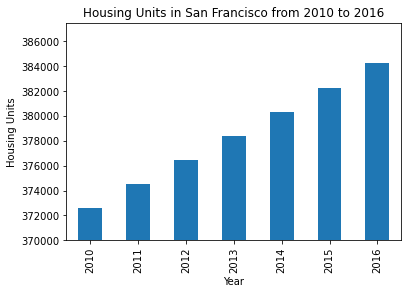

In [28]:
# Plot the average housing units per year

fig_housing_units = housing_units.plot(kind='bar', title="Housing Units in San Francisco from 2010 to 2016")
fig_housing_units.set_ylim(370000,387500)
fig_housing_units.set_xlabel("Year")
fig_housing_units.set_ylabel("Housing Units")

plt.show(fig_housing_units)

## Average Prices Per Square Foot
### Average Gross Rent In San Francisco Per Year

In [29]:
# Average gross rent and average sale price per square foot
gross_rent = sfo_data[["sale_price_sqr_foot","gross_rent"]].groupby([sfo_data.index]).mean()
gross_rent

,sale_price_sqr_foot,gross_rent
year,,
2010,369.344353,1239
2011,341.903429,1530
2012,399.389968,2324
2013,483.600304,2971
2014,556.277273,3528
2015,632.540352,3739
2016,697.643709,4390


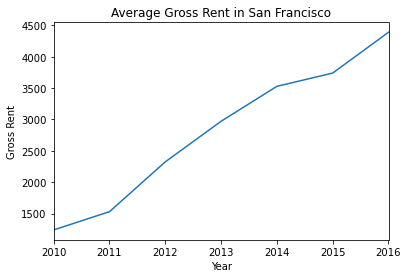

In [30]:
# Slice for gross rent
gross_rent_df = gross_rent["gross_rent"]

# Plot
gross_rent_df = gross_rent_df.plot(kind='line', title="Average Gross Rent in San Francisco")
gross_rent_df.set_xlabel("Year")
gross_rent_df.set_ylabel("Gross Rent")

plt.show(gross_rent_df)


### Average Sales Price per Year

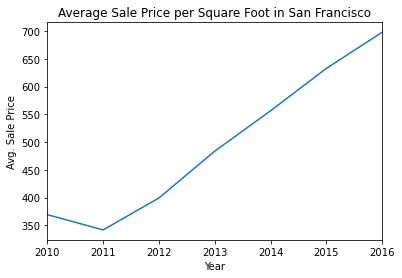

In [31]:
# Slice for Average Sales Price
sales_price_df = gross_rent["sale_price_sqr_foot"]

# Plot
sales_price_df = sales_price_df.plot(kind='line', title="Average Sale Price per Square Foot in San Francisco")
sales_price_df.set_xlabel("Year")
sales_price_df.set_ylabel("Avg. Sale Price")

plt.show(sales_price_df)

## Average Prices by Neighborhood

In [32]:
# Group by year and neighborhood and then create a new dataframe of the mean values
neighborhood_df = sfo_data.drop(columns=["housing_units","gross_rent"])
neighborhood_df = neighborhood_df.groupby([sfo_data.index,'neighborhood']).mean()
neighborhood_df = neighborhood_df.reset_index()

neighborhood_df.head()


,year,neighborhood,sale_price_sqr_foot
0,2010,Alamo Square,291.182946
1,2010,Anza Vista,267.932583
2,2010,Bayview,170.098665
3,2010,Buena Vista Park,347.394919
4,2010,Central Richmond,319.027623


In [33]:
# Use hvplot to create an interactive line chart of the average price per sq ft.
def choose_neighborhood(neighborhood_df):

    return neighborhood_df.hvplot.line(
    'year',
    'sale_price_sqr_foot',
    groupby = 'neighborhood',
    xlabel="Year",
    ylabel="Avg. Sale Price per. Square foot")

choose_neighborhood(neighborhood_df)

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

## The Top 10 Most Expensive Neighborhoods

In [34]:
# Get Data for Top 10 expensive neighborhoods
expensive_sales_df = sfo_data
expensive_sales_df = expensive_sales_df.groupby(['neighborhood']).mean()
expensive_sales_df = expensive_sales_df.nlargest(10, 'sale_price_sqr_foot')
expensive_sales_df

# Plot the data from top 10 expensive neighborhoods using bar chart
expensive_sales_df.hvplot.bar(
    'neighborhood',
    'sale_price_sqr_foot',
    xlabel="Neighborhood",
    ylabel="Avg. Sale Price per. Square foot",
    title='Top 10 Expensive Neighborhoods in SFO',
    rot=90)


:Bars   [neighborhood]   (sale_price_sqr_foot)

## Parallel Coordinates and Parallel Categories Analysis

### Create a Parallel Coordinates Plot

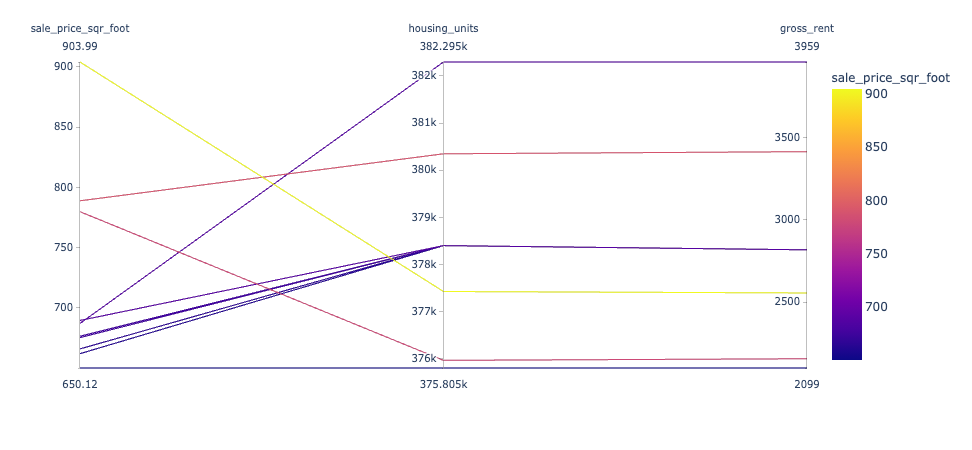

In [35]:
# Reset Index
expensive_sales_df = expensive_sales_df.reset_index()
# Parallel Coordinates Plot
px.parallel_coordinates(expensive_sales_df, color = 'sale_price_sqr_foot')


### Create a Parallel  Categories Plot

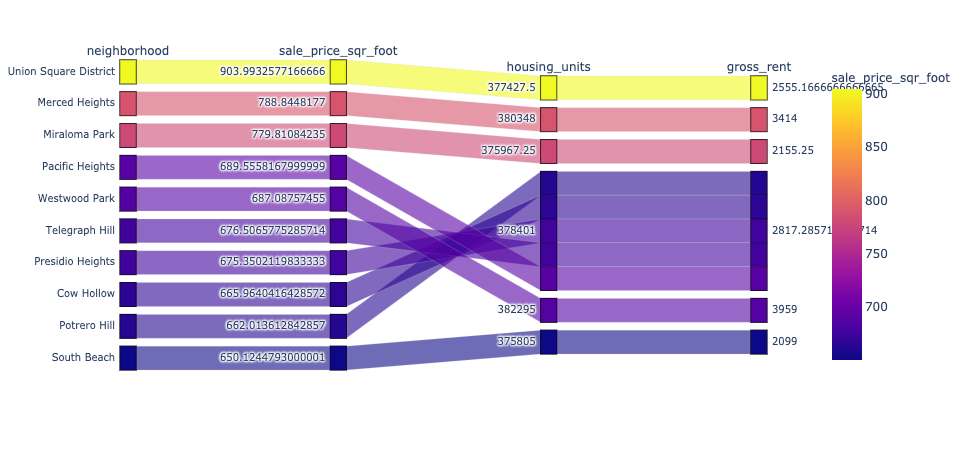

In [36]:
# Parallel Categories Plot
px.parallel_categories(
    expensive_sales_df,
    dimensions=["neighborhood","sale_price_sqr_foot","housing_units","gross_rent"],
    color= "sale_price_sqr_foot"
)

## Neighborhood Map

In [37]:
# Load neighborhoods coordinates data
file_path = Path("Resources/neighborhoods_coordinates.csv")
neighborhood_locations_df = pd.read_csv(file_path)
neighborhood_locations_df.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


In [38]:
# Calculate mean values for each neighborhood
avg_sales_df = sfo_data
avg_sales_df = avg_sales_df.groupby(['neighborhood']).mean()
avg_sales_df = avg_sales_df.reset_index()
avg_sales_df.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
0,Alamo Square,366.020712,378401.0,2817.285714
1,Anza Vista,373.382198,379050.0,3031.833333
2,Bayview,204.588623,376454.0,2318.400000
3,Bayview Heights,590.792839,382295.0,3739.000000
4,Bernal Heights,576.746488,379374.5,3080.333333


In [39]:
# Join average values with the neighborhood locations
joined_df = (
    pd.concat([neighborhood_locations_df, avg_sales_df], axis=1, sort=True)
    .dropna()
)
joined_df.head()

,Neighborhood,Lat,Lon,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
0,Alamo Square,37.791012,-122.402100,Alamo Square,366.020712,378401.0,2817.285714
1,Anza Vista,37.779598,-122.443451,Anza Vista,373.382198,379050.0,3031.833333
2,Bayview,37.734670,-122.401060,Bayview,204.588623,376454.0,2318.400000
3,Bayview Heights,37.728740,-122.410980,Bayview Heights,590.792839,382295.0,3739.000000
4,Bernal Heights,37.728630,-122.443050,Bernal Heights,576.746488,379374.5,3080.333333


### Mapbox Visualization

In [27]:
import plotly.express as px
joined_plot = px.scatter_mapbox(
        joined_df,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco",
        zoom=3,
        width=1000,
)

joined_plot.show()

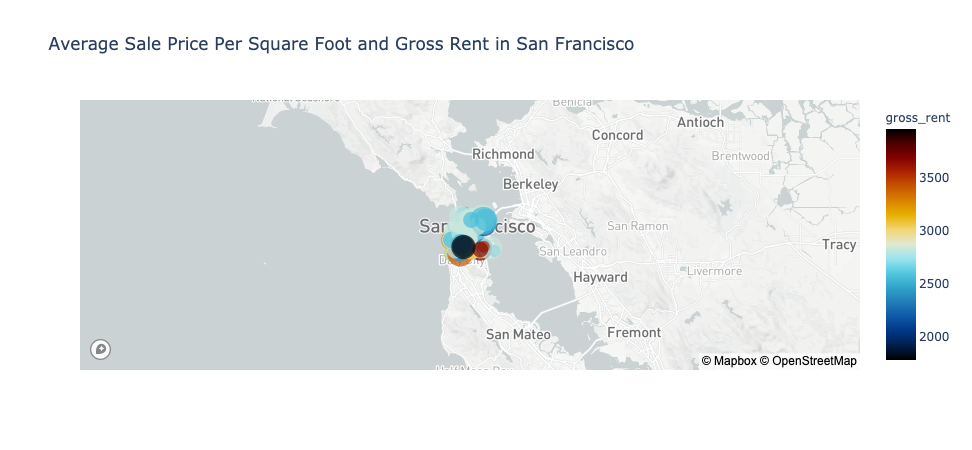

In [40]:
# Create a scatter mapbox to analyze neighborhood info

joined_plot = px.scatter_mapbox(
        joined_df,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco"
)

joined_plot.show()